# Correcting Sample Bias with Transfer Leanring

<center>
<figure>
<img src="../_static/images/sample_bias_img.png" alt="sample bias illustration">
    <figcaption>Illustration of sample bias</figcaption>
</figure>
</center>

For many statistical applications, it is crucial that the data set used to make estimates is distributed in the same way as the target population. For example, in medicine, to estimate the effectiveness of a drug on a population, it is important that the sample of patients considered in the study is representative of the whole population. The same thing happens for polls, to estimate the voting percentages on the whole country, it is important that the sample of people surveyed are representative of the whole country population (the proportion of social and professional categories should be respected as well as the distribution of ages etc...).

In machine learning, the same principle applies. When a model is trained on a dataset, it is important that this dataset is representative of the data on which the model will be applied later. For example, for a classification problem, if one of the classes is under-represented compared to the others, the model will tend to make more errors on this class.

In mathematical terms, this question of the representativeness of the training dataset with respect to the test dataset is written:

$$P_{train}(X, Y) = P_{test}(X, Y)$$

Where $X$ represent the inputs variables (for instance, the age, the height and the number of medical intervention of the patient) and $Y$ is the output variable (the survival time for instance).

This assumption of representativeness is rarely verified as the training data set is often "biased" with respect to the testing set. For example, in a survey, one socio-professional category is over-represented compared to the others, or the patients considered are predominantly of one sex rather than another. This issue is called "sample bias" and can be formulated as follows:

$$P_{train}(X) \neq P_{test}(X)$$

Because of sample bias, the estimation of the variable of interest $Y$ based on $X$ will often be biased as well. However, if we have access to the distribution of the target population $P_{test}(X)$, it is possible to correct the estimation. For example, in the case of surveys, it is often possible to know the true distribution of social categories over the whole country. One will then give different weights to the votes of each person in the polling sample according to their social category. Thus, the vote of a person from an under-represented category in the sample will have a greater weight and vice versa. Mathematically speaking, the optimal weights that should be used to correct the sample bias is the following:

$$w(X) = \frac{P_{test}(X)}{P_{train}(X)}$$

We can easily see that the weights $w(X)$ verify for any function $f$,

$$E_{X \sim P_{train}(X)}[w(X) f(X)] = E_{X \sim P_{test}(X)}[f(X)]$$

Which is convenient for many applications. Without entering in too much details, we can see, for example, in a case of binary vote where $Y \in \{0, 1\}$, if $Y = f(X)$, the above formula states that the proportion of people voting $1$ in the test population will be accurately estimated by applying the importance weighting $w(X)$ to the training set.

In practice, however, one does not access directly to the distributions $P_{train}(X)$ and $P_{test}(X)$ but to samples drawn according to these distributions $X_{train} \sim P_{train}(X)$ and $X_{test} \sim P_{test}(X)$. The use of samples instead of distribution harden the estimation of $w(X)$, that's why instance-based transfer learning methods have been developed to perform non-parametric estimation of $w(X)$ based on $X_{train}$ and $X_{test}$. 

In the transfer learning setting, the sample bias issue is characterized as an unsupervised domain adaptation problem. The problem is unsupervised because one only has access to the output variable $Y$ in the training set ($X_{train}, Y_{train}$). In the test set, only $X_{test}$ is available. This problem is also characterized by what is called the "covariate-shift" assumption, this technical term means that the conditional training and test distributions are the same $P(Y_{train} | X_{train}) = P(Y_{test} | X_{test})$. This is the case for example in the biased poll issue, as the distribution of votes within the same social category is the same for the train and the test samples. Thus, according to the [ADAPT flowchart](https://adapt-python.github.io/adapt/map.html), one should choose an instance-based approach which reweights the training data in order to match the test distribution.

Let's now look at how transfer learning can tackle sample bias in a concrete case. We will use in the following the [diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html) dataset from scikit-learn.

## Sample Bias on the diabetes dataset

In [38]:
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

Above is the description of the "diabetes" dataset, this dataset represents a study of the evolution of diabetes built on 442 patients. On one side we have observation variables of the patient (age, weight, blood data...) that we will arrange in a matrix $X$ and on the other side we have a variable of interest that gives quantitatively the evolution of the disease that we will arrange in a vector $y$. The large values of $y$ correspond to an important progression of the disease.

In [40]:
data = load_diabetes(as_frame=True)
print(data["DESCR"])

X = data["data"]
y = data['target']

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

We consider that the data sets $X$, $y$ are well distributed, i.e. that they represent the distribution of all people with diabetes. For our study, we artificially create a "sample bias" on our data set. To do so, we randomly draw some points $(x_i, y_i)$ from $X, y$ with a bias on the "age" variable. We put more weight around the lowest ages. We simulate here a case where the sample of patients used to study the evolution of diabetes would be globally younger than the whole population.

In [41]:
np.random.seed(123)
sample_bias = np.exp(-20*np.abs(X["age"]+0.06))
biased_index = np.random.choice(X.index, len(X), p=sample_bias/sample_bias.sum())
biased_X = X.loc[biased_index]
biased_y = y.loc[biased_index]

biased_age = biased_X["age"]
age = X["age"]

We can now observe the "sample bias" on the age variable:

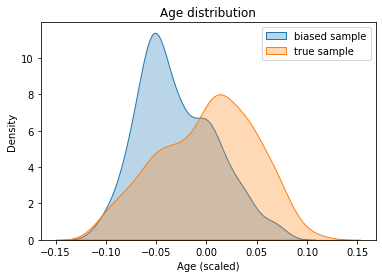

In [42]:
sns.kdeplot(biased_age.values, shade=True, alpha=0.3, label="biased sample")
sns.kdeplot(age.values, shade=True, alpha=0.3, label="true sample")
plt.title("Age distribution"); plt.xlabel("Age (scaled)");
plt.legend(); plt.show()

We can see above a clear bias between the age distribution for the source sample (in blue) and the whole population (in orange). Let's note right away that the "true" age distribution is assumed to be known during the study. Indeed, this information may be available from statistical or health organizations (which report the age of diabetes patients). It can be noted that the orange distribution follows more or less a Gaussian distribution, which is what we find in some research papers: [Diabetes and Recreational Diving: Guidelines for the Future](https://www.researchgate.net/figure/Age-distribution-of-registered-diabetic-divers-in-the-UK-on-joining-the-database_fig1_242671518)

A question that may arise at this point is: "Is this bias over ages problematic for the study of the evolution of the diabetes disease?" To check this, we can look at the correlation between the age of the patients and the evolution of the disease. Indeed, if this correlation is null (the distribution of the variable $Y$ is the same for all ages: $P(Y|\text{age}) = P(Y)$) there is no problem to have a biased sample for this variable.

However, we observe below that there is a positive correlation (of the order of 0.2) between the age of the patient and the disease progression variable.

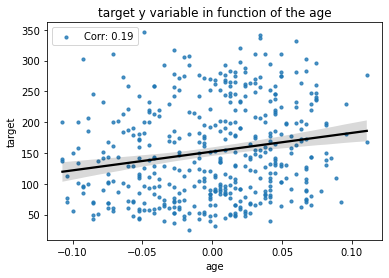

In [43]:
corr = np.corrcoef(X["age"], y)[0,1]
sns.regplot(x=X["age"], y=y, label="Corr: %.2f"%corr,
            scatter_kws={"s":10}, line_kws={"color":"k"})
plt.title("target y variable in function of the age");
plt.legend(); plt.show();

Because of this correlation between the age variable and the target variable, the "sample bias" on the age will be reflected on the target variable $Y$ as we have:

$$P_{test}(Y) = \int_{x} P_{test}(Y|X=x) P_{test}(X=x)$$

As we have the covariate shift assumption ($P_{test}(Y | X=x) = P_{train}(Y | X=x)$), if $Y$ and $X$ were independent, we would have $P(Y|X=x) = P(Y)$ and then $P_{test}(Y | X=x) = P_{train}(Y | X=x) = P_{train}(Y)$ which would lead to:

$$P_{test}(Y) = \int_{x} P_{train}(Y) P_{test}(X=x) = P_{train}(Y)$$

Therefore, there would be no difference on the distribution $P(Y)$ between tre training and the testing set. But when $P(Y|X) \neq P(Y)$, it is very likely that we have $P_{train}(Y) \neq P_{test}(Y)$.

To be convinced, we represent the distributions $P(Y)$ for the biased and the true sample. Note that this is not possible in practice because we do not have access to the variable $Y_{test}$. We can see on the Figure below, a clear difference between the two distributions. 

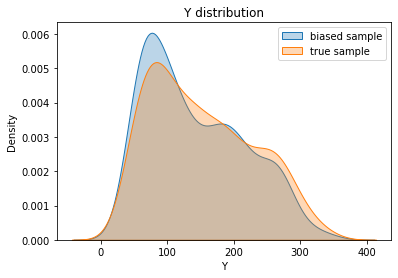

In [44]:
sns.kdeplot(biased_y.values, shade=True, alpha=0.3, label="biased sample")
sns.kdeplot(y.values, shade=True, alpha=0.3, label="true sample")
plt.title("Y distribution"); plt.xlabel("Y");
plt.legend(); plt.show()

Now let's consider a simple task for our study of the evolution of diabetes. Let's try to evaluate the mean or a quantile of the target distribution. This value can be used as a threshold to determine the status of a patient. Let's say for example that patients above the 75% quantile are considered in a severe state and the others in a stable state. A comparison of the two distributions is shown below:

In [45]:
pd.concat((
pd.DataFrame(y).describe(percentiles=[0.5, 0.75, 0.9]),
pd.DataFrame(biased_y.values, columns=["biased target"]).describe(percentiles=[0.5, 0.75, 0.9])
), axis=1)

,target,biased target
count,442.000000,442.000000
mean,152.133484,142.389140
std,77.093005,74.338154
min,25.000000,25.000000
50%,140.500000,125.000000
75%,211.500000,200.000000
90%,265.000000,258.000000
max,346.000000,346.000000


We can see that because of the sample bias, the estimations of the mean or quantiles of our target distribution is biased. We are about 10 points below for the mean, the median and the 75% quantile.

## Applying Transfer Learning for correcting sample bias

We will now try to correct our biased sample using a transfer learning method. For this, we have seen that the [ADAPT flowchart](https://adapt-python.github.io/adapt/map.html) suggests to use a reweighting method. This kind of methods will give a different weights to every instance in our biased sample according to their age to match the true age distribution.

Let's take the Kullback–Leibler Importance Estimation Procedure (KLIEP) method for example. We are not going to go into the details of this method which require a certain mathematical background, in particular a knowledge of kernel methods. What you need to know is that KLIEP will automatically assign a weight to each instance in our biased sample so that the reweighted distribution of ages will resemble to the target distribution as much as possible. Those who are interested can look at the [KLIEP documentation](https://adapt-python.github.io/adapt/generated/adapt.instance_based.KLIEP.html) or read [Sugiyama's paper](https://proceedings.neurips.cc/paper/2007/file/be83ab3ecd0db773eb2dc1b0a17836a1-Paper.pdf).

Like any machine learning method, KLIEP uses hyper-parameters (here a choice of kernel and the parameters of this kernel as for the SVM of scikit-learn). For a Gaussian kernel (the default one) the choice of the `gamma` parameter plays an important role in the success of the method. To choose it well, KLIEP proposes the possibility to try several gammas and to select the one that reduces the most the gap between the two distributions (this gap being measured with a proxy of the Kullback Leibler called the [J-score](https://adapt-python.github.io/adapt/generated/adapt.metrics.neg_j_score.html)).

Let's now reweight our biased sample! We have chosen a list of values of `gamma` evolving on the power of $10$ between $10^{-4}$ and $10^4$. The J-score for each value is displayed, the higher the J-score the better.

In [46]:
from adapt.instance_based import KLIEP

kliep = KLIEP(kernel="rbf", gamma=[10**(i-4) for i in range(9)], random_state=0)
kliep_weights = kliep.fit_weights(biased_age.values.reshape(-1, 1), age.values.reshape(-1, 1))

Cross Validation process...
Parameters {'gamma': 0.0001} -- J-score = -0.000 (0.000)
Parameters {'gamma': 0.001} -- J-score = 0.000 (0.000)
Parameters {'gamma': 0.01} -- J-score = 0.000 (0.000)
Parameters {'gamma': 0.1} -- J-score = -0.000 (0.000)
Parameters {'gamma': 1} -- J-score = 0.003 (0.000)
Parameters {'gamma': 10} -- J-score = 0.030 (0.003)
Parameters {'gamma': 100} -- J-score = 0.169 (0.025)
Parameters {'gamma': 1000} -- J-score = 0.287 (0.055)
Parameters {'gamma': 10000} -- J-score = 0.260 (0.069)


We see above that we have called the `fit_weights` method of KLIEP. This method takes in the biased and the unbiased datasets and returns the weights for the best `gamma` (the one with the highest J-score, here `gamma=1000.`).

To have an idea of the reweighting done by KLIEP, we can display the weights given by KLIEP according to the "age" variable:

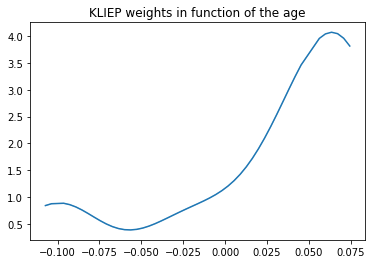

In [47]:
sns.lineplot(x=biased_age.values, y=kliep_weights)
plt.title("KLIEP weights in function of the age");
plt.show();

You can see on the Figure above, that KLIEP gives a higher weight to the older patients, precisely to compensate the fact that the younger patients are over-represented in our sample.

Now that we have source weights, we will draw a new sample: the "debiased sample", by taking randomly input data in our biased sample. The random choice will be weighted by the KLIEP weights. Note that we can draw as many instances as we want, here we will take $2000$, in general the more we take the better. Please don't forget that we draw with discount, so the same patient can be drawn several times.

In [48]:
np.random.seed(123)
debiasing_index = np.random.choice(len(biased_age), 2000, p=kliep_weights/kliep_weights.sum())
debiased_age = biased_age.iloc[debiasing_index]
debiased_y = biased_y.iloc[debiasing_index]

Let's now look at the correction made on the ages. We can see on the left Figure that our "debiased" sample has an age distribution very close to the one of the "real" sample, which is great! For comparison, we have shown the biased distribution on the Figure on the right.

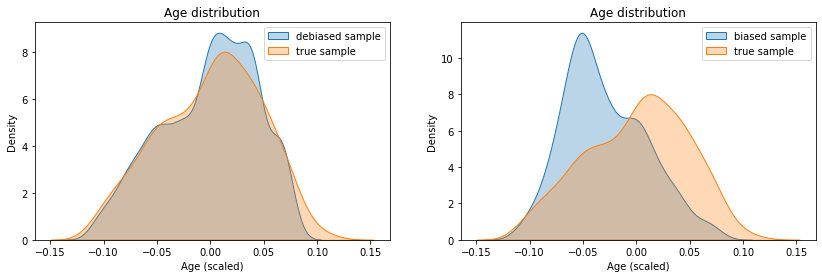

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for ax, x, label in zip(axes, [debiased_age, biased_age], ["debiased sample", "biased sample"]):
    sns.kdeplot(x.values, shade=True, alpha=0.3, label=label, ax=ax)
    sns.kdeplot(age.values, shade=True, alpha=0.3, label="true sample", ax=ax)
    ax.set_title("Age distribution"); ax.set_xlabel("Age (scaled)"); ax.legend();
plt.show()

Now, all that remains is to compute our quantile estimations on the target variable with our debiased sample.

In [50]:
pd.concat((
pd.DataFrame(y.values, columns=["target"]).describe(percentiles=[0.5, 0.75, 0.9]),
pd.DataFrame(debiased_y.values, columns=["debiased target"]).describe(percentiles=[0.5, 0.75, 0.9]),
pd.DataFrame(biased_y.values, columns=["biased target"]).describe(percentiles=[0.5, 0.75, 0.9])
), axis=1)

,target,debiased target,biased target
count,442.000000,2000.000000,442.000000
mean,152.133484,148.301000,142.389140
std,77.093005,77.939673,74.338154
min,25.000000,25.000000,25.000000
50%,140.500000,134.000000,125.000000
75%,211.500000,212.000000,200.000000
90%,265.000000,265.000000,258.000000
max,346.000000,346.000000,346.000000


And here we are!

It's not perfect yet, but you can clearly see that the new estimations are closer to the target values! In particular the estimation of the quantiles at 75% and 90% is almost perfect!

## Hidden bias and features importance estimation

Ok, let's now go a little bit further... In the previous example, the bias was known and easily identifiable (the disparity on the patients' ages). There was therefore only one variable to correct. However, in some cases, the bias is on a hidden variable that is not accessible at the time of estimation. This bias affects all the variables and it is not easy to know which variables to correct.

Fortunately, transfer learning methods can handle multivariate bias in the same way as univariate one as long as a dataset drawn according to the unbiased (test) distribution is available.

We will assume in this example that there is a strong bias on the "sex" variable in our sample of patients. We assume that one sex is represented 5 times more than the other. We also assume that this variable is not available in the input variables $X$. As the "sex" variable is correlated to the others, we are then facing a bias on each of the input variable without being able to identify from where comes the bias. We also assume that we have access to a unbiased dataset (i.e. an estimate of the distribution of the input variables $X$ in the whole population).

In [51]:
X = data["data"]
y = data['target']

np.random.seed(0)
sample_bias = np.ones(len(X))
sample_bias[X.sex < 0] *= 5.
X = X.drop(["sex"], axis=1)
biased_index = np.random.choice(X.index, len(X), p=sample_bias/sample_bias.sum())
biased_X = X.loc[biased_index]
biased_y = y.loc[biased_index]

This generalized bias can be visualized by comparing the PCAs of the biased and unbiased datasets:

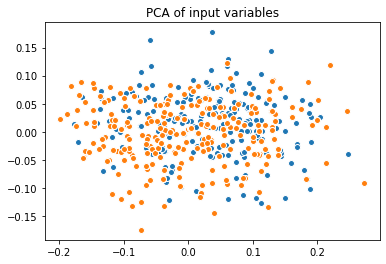

In [52]:
from sklearn.decomposition import PCA
X_pca = PCA(2).fit_transform(np.concatenate((X, biased_X)))
plt.scatter(X_pca[:len(X), 0], X_pca[:len(X), 1], edgecolor="w", label="Unbiased dataset")
plt.scatter(X_pca[len(X):, 0], X_pca[len(X):, 1], edgecolor="w", label="Biased dataset")
plt.title("PCA of input variables"); plt.show();

A task that is often considered in this type of medical study is the estimation of the importances of the input variables with respect to the target variable. In this case of a study on diabetes, we are looking for the influence that each of the patient feature has on the evolution of the disease.

One approach to determine these importances is to compute the parameters of a linear model $\beta_j$ such that:

$$\sum_{j=0}^{\text{nb of variables}} \beta_j x_{ij} \simeq y_{i}$$

For any $i \in [0, \text{nb of patients}]$, with $x_{ij}$ the data variable $j$ for patient $i$ and $y_i$ the disease progression variable for patient $i$.

The fact that our data set $(X_{train}, y_{train})$ used to determine the $\beta_j$ parameters is biased will induce a bias on the estimation of these $\beta_j$. We will therefore compare the estimates of these parameters for three linear models:

- The one fitted with the unbiased data $(X_{test}, y_{test})$ (the ground truth)
- The one fitted with the $(X_{train}, y_{train})$ biased data
- The one fitted with the data $(X'_{train}, y'_{train})$ debiased by a transfer method.

To diversify, we will use another bias correction method: [Kernel Mean Matching (KMM)](https://adapt-python.github.io/adapt/generated/adapt.instance_based.KMM.html). KMM is also a kernel method where the kernel parameters (in particular the `gamma` parameter for a Gaussian kernel) must be chosen. KMM, unlike KLIEP does not have an integrated procedure for the choice of the parameters. We will therefore use some [ADAPT tools](https://adapt-python.github.io/adapt/generated/adapt.metrics.make_uda_scorer.html) to conduct an unsupervised gridsearch for the choice of `gamma`.

In [53]:
import adapt.metrics
import importlib
importlib.reload(adapt.metrics)
from adapt.metrics import make_uda_scorer, neg_j_score

In [54]:
from adapt.instance_based import KMM
from adapt.metrics import make_uda_scorer, neg_j_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Instantiate KMM model with a random gamma parameter
kmm = KMM(
    estimator=Ridge(0.1), 
    Xt=X,
    kernel="rbf",  # Gaussian kernel
    gamma=0.,     # Bandwidth of the kernel
    verbose=0,
    random_state=0
)

# Create a score function from the neg_j_score metric and biased_X, X
score = make_uda_scorer(neg_j_score, biased_X, X)

# Launch the gridsearch on four gamma parameters [0.1, 1., 10., 100., 1000.]
gs = GridSearchCV(kmm, {"gamma": [0.1, 1., 10., 100., 1000.]},
                  scoring=score,
                  return_train_score=True, cv=5, verbose=0)
gs.fit(biased_X, biased_y);

# Print results (the neg_j_score is given in "train_score")
keys = ["params", 'mean_train_score', 'std_train_score']
results =  [v for k, v in gs.cv_results_.items() if k in keys]
best = results[1].argmin()
print("Best Params %s -- Score %.3f (%.3f)"%
      (str(results[0][best]), results[1][best], results[2][best]))
print("-"*50)
for p, mu, std in zip(*results):
    print("Params %s -- Score %.3f (%.3f)"%(str(p), mu*1000., std*1000.))

Best Params {'gamma': 100.0} -- Score -0.000 (0.000)
--------------------------------------------------
Params {'gamma': 0.1} -- Score 0.012 (0.288)
Params {'gamma': 1.0} -- Score -0.033 (0.269)
Params {'gamma': 10.0} -- Score -0.064 (0.067)
Params {'gamma': 100.0} -- Score -0.264 (0.088)
Params {'gamma': 1000.0} -- Score 0.370 (0.392)


The best parameters is the one with the smallest `neg_j_score` which is `gamma=100` here. Note that this gridsearch have been done whithout using the `y` data. Remind that the J-score is a metric that measure the divergence between the debiased distribution and the unbiased distribution.

Now that we have determined the value of the `gamma` parameter we can fit KMM to obtain the debiasing weight vector.

In [55]:
kmm = KMM(
    estimator=Ridge(), 
    Xt=X.values,
    kernel="rbf",  # Gaussian kernel
    gamma=100.,     # Bandwidth of the kernel
    verbose=0,
    random_state=0
)
weights = kmm.fit_weights(biased_X, X);

Let's now fit the three linear models with the three types of data sets (biased, unbiased and debiased). To have a better estimate of the coeficients of the linear regressions we will repeat the experiments 100 times.

In [56]:
true_coefs = []
biased_coefs = []
debiased_coefs = []

for _ in range(100):
    bs = np.random.choice(X.index, len(X))
    biased_bs = np.random.choice(biased_X.index, len(X))
    debiased_bs = np.random.choice(biased_X.index, len(biased_X), p=weights/weights.sum())
    true_coefs.append(Ridge(0.1).fit(X.loc[bs], y.loc[bs]).coef_)
    biased_coefs.append(Ridge(0.1).fit(biased_X.loc[biased_bs], biased_y.loc[biased_bs]).coef_)
    debiased_coefs.append(Ridge(0.1).fit(biased_X.loc[debiased_bs], biased_y.loc[debiased_bs]).coef_)

We can now plot the results...

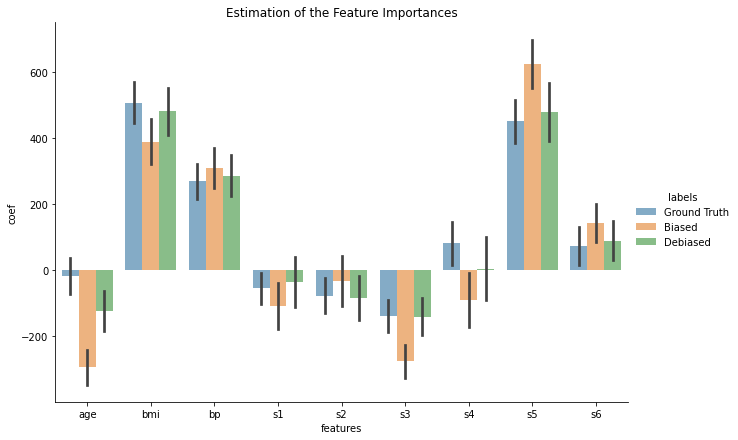

In [57]:
arr = np.concatenate((true_coefs, biased_coefs, debiased_coefs)).ravel()
x = list(X.columns)*(len(true_coefs)+len(biased_coefs)+len(debiased_coefs))
labels = (["Ground Truth"]*len(true_coefs)*9 + ["Biased"]*len(biased_coefs)*9 +
          ["Debiased"]*len(debiased_coefs)*9)
df = pd.DataFrame([arr, x, labels], index=["coef", "features", "labels"]).transpose()
sns.catplot(data=df, x="features", y="coef", hue="labels",
            kind="bar", ci="sd", alpha=.6, height=6, aspect=1.5)
plt.title("Estimation of the Feature Importances"); plt.show();

Well done KMM! 

We can clearly see that the coefficients obtained after debiasing the data are much closer to the ground truth coefficients than those of the biased model. We can see, for instance, that the biased model overestimate the importance of the variable "age", "s3" and "s5" and underestimate that of "bmi" (body mass index). We can also notice that the biased model have made an inversion: it gives a negative contribution to the parameter "s4" whereas the real contribution of this variable is rather positive. This type of error can lead to a wrong treatment! For example here, "s4" corresponds to the cholesterol level. Because of the bias in the model, a doctor may recommand to his patients the opposite diet that the one which should be favored! Notice that the debiased model does not give a confident assessment on the contribution of this variable and would then not mislead the treatment. This shows the importance of debiasing the dataset before conducting a study!